Train shape: (1460, 81)
Test shape: (1459, 80)

Sample rows from train data:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

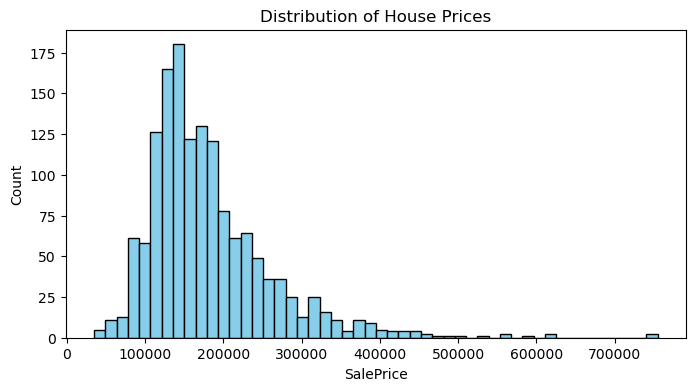

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nSample rows from train data:")
print(train.head())


print("\nSalePrice summary stats:")
print(train['SalePrice'].describe())


plt.figure(figsize=(8,4))
plt.hist(train['SalePrice'], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.title("Distribution of House Prices")
plt.show()


------ Train Info ------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-nul

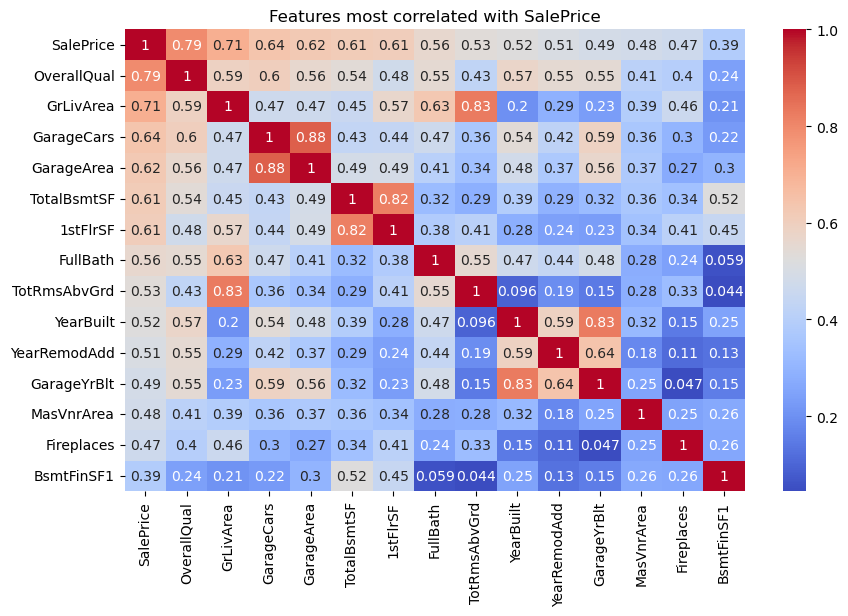

In [2]:

print("------ Train Info ------")
print(train.info())


missing = (train.isnull().sum() / len(train)) * 100
missing = missing.sort_values(ascending=False)
print("\nTop 20 missing values (in %):")
print(missing.head(20))


num_cols = train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()


if "SalePrice" in num_cols:
    num_cols.remove("SalePrice")

print("\nNumeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))


corr = train[num_cols + ["SalePrice"]].corr()
top_corr = corr["SalePrice"].sort_values(ascending=False).head(15)

print("\nTop correlated features with SalePrice:")
print(top_corr)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(train[top_corr.index].corr(), annot=True, cmap="coolwarm")
plt.title("Features most correlated with SalePrice")
plt.show()


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_cols = train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# remove target variable from numeric list
if "SalePrice" in num_cols:
    num_cols.remove("SalePrice")

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="Missing")),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

print("Preprocessor is ready ✅")



Numeric columns: 37
Categorical columns: 43
Preprocessor is ready ✅


In [22]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.pipeline import Pipeline

y = np.log1p(train['SalePrice'])
X = train.drop('SalePrice', axis=1)


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0))
])

ridge_model.fit(X_train, y_train)
preds_ridge = ridge_model.predict(X_val)

mse_ridge = mean_squared_error(y_val, preds_ridge)
rmse_ridge = np.sqrt(mse_ridge)
print("Ridge RMSE (log target):", rmse_ridge)

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
preds_rf = rf_model.predict(X_val)

mse_rf = mean_squared_error(y_val, preds_rf)
rmse_rf = np.sqrt(mse_rf)
print("Random Forest RMSE (log target):", rmse_rf)



Ridge RMSE (log target): 0.13091656250806566
Random Forest RMSE (log target): 0.14689866268887572


In [23]:
from sklearn.model_selection import cross_val_score
import pandas as pd

# Define models in a dictionary for easy looping
models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    )
}

def evaluate_model(name, model, X, y):
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    scores = cross_val_score(
        pipe, X, y,
        scoring="neg_root_mean_squared_error",
        cv=5, n_jobs=-1
    )
    return -scores.mean(), -scores.std()

results = []
for name, model in models.items():
    mean_rmse, std_rmse = evaluate_model(name, model, X, y)
    results.append((name, mean_rmse, std_rmse))


results_df = pd.DataFrame(results, columns=["Model", "CV_RMSE_Mean", "CV_RMSE_Std"])
print(results_df)



          Model  CV_RMSE_Mean  CV_RMSE_Std
0         Ridge      0.144360    -0.025981
1  RandomForest      0.143237    -0.008710


In [24]:
from sklearn.ensemble import RandomForestRegressor

final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300, 
        random_state=42,
        n_jobs=-1
    ))
])

final_model.fit(X, y)

test_preds = final_model.predict(test)

test_preds_final = np.expm1(test_preds)

submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": test_preds_final
})

submission.to_csv("submission.csv", index=False)

print("✅ Submission file 'submission.csv' created successfully using RandomForest!")



✅ Submission file 'submission.csv' created successfully using RandomForest!
